In [ ]:
import pandas as pd
import numpy as np
normal = pd.read_csv('data.csv', sep=',', header = None)
abnormal = pd.read_csv('data_abnormal.csv', sep=',', header = None)
abnormal

In [ ]:
normal

In [3]:
X_train = np.concatenate([normal.T, abnormal.T], axis =0)

In [16]:
import pandas as pd
import numpy as np
y_train = np.concatenate([np.ones(5888), np.zeros(2878)])

y_train

array([1., 1., 1., ..., 0., 0., 0.])

In [5]:
import keras
# from keras.utils import objectives
import numpy as np
from math import floor
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()

from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector, Layer
from keras.layers.core import Flatten, Dense, Dropout, Lambda
# from keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
# from keras import objectives
# import tensorflow.contrib.keras as keras
from tensorflow.python.framework.ops import disable_eager_execution

In [6]:
class VAE:
    def __init__(self, input_dim, latent_dim, hidden_dims, batch_size, optimizer='rmsprop', epsilon_std = .01):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.epsilon_std = epsilon_std
        self.build_model()

    def build_model(self):
        input_layer = Input(batch_shape=(self.batch_size, self.input_dim))
        self.build_encoder(input_layer)
        self.build_decoder()
        self.autoencoder = Model(input_layer, self.x_decoded_mean)
        vae_loss = self._get_vae_loss()
        self.autoencoder.compile(optimizer=self.optimizer, loss=vae_loss)

    def build_encoder(self, input_layer):
        prev_layer = input_layer
        for q in self.hidden_dims:
            hidden = Dense(q, activation='relu')(prev_layer)
            prev_layer = hidden
        self._build_z_layers(hidden)
        self.encoder = Model(input_layer, self.z_mean)

    def _build_z_layers(self, hidden_layer):
        self.z_mean = Dense(self.latent_dim)(hidden_layer)
        self.z_log_sigma = Dense(self.latent_dim)(hidden_layer)

    def build_decoder(self):
        z = self._get_sampling_layer()
        prev_layer = z
        for q in self.hidden_dims:
            hidden = Dense(q, activation='relu')(prev_layer)
            prev_layer = hidden
        self.x_decoded_mean = Dense(self.input_dim, activation='sigmoid')(prev_layer)

        # Build the stand-alone generator
        generator_input = Input((self.latent_dim,))
        prev_layer = generator_input
        for q in self.hidden_dims:
            hidden = Dense(q, activation='relu')(prev_layer)
            prev_layer = hidden
        gen_x_decoded_mean = Dense(self.input_dim, activation='sigmoid')(prev_layer)
        self.generator = Model(generator_input, gen_x_decoded_mean)

    def _get_sampling_layer(self):
        def sampling(args):
            z_mean, z_log_sigma = args
            epsilon = K.random_normal(shape=(self.batch_size, self.latent_dim),
                                      mean=0., stddev=self.epsilon_std)
            return z_mean + z_log_sigma * epsilon
        return Lambda(sampling, output_shape=(self.latent_dim,))([self.z_mean, self.z_log_sigma])

    def _get_vae_loss(self):
        z_log_sigma = self.z_log_sigma
        z_mean = self.z_mean
        def vae_loss(x, x_decoded_mean):
            reconstruction_loss = tf.keras.metrics.mean_squared_error(x, x_decoded_mean)
            kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
            return reconstruction_loss + kl_loss

        return vae_loss
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(64, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):   #encode the images into the latent space
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    #the reparametrization trick suggests that we randomly sample 'e' from a unit Gaussian,
    #and then shift the randomly sampled 'e' by the latent distribution's mean 'mu' and scale it 
    #by the latent distribution's variance 'rho'.

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):  #decodes the latent space into the image
        # logits = self.generator(tf.concat([z, self.z_mean], 1))
        logits = self.generator(self.z_mean)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [7]:
class VAE_LSTM(VAE):
    def __init__(self, input_dim, latent_dim, hidden_dims, timesteps, batch_size, optimizer='rmsprop', epsilon_std = .01):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims
        self.batch_size = batch_size
        self.timesteps = timesteps
        self.optimizer = optimizer
        self.epsilon_std = epsilon_std
        self.build_model()

    def build_model(self):
        input_layer = Input(shape=(self.timesteps, self.input_dim,))
        self.build_encoder(input_layer)
        self.build_decoder()
        self.autoencoder = Model(input_layer, self.x_decoded_mean)
        vae_loss = self._get_vae_loss()
        self.autoencoder.compile(optimizer=self.optimizer, loss=vae_loss)

    def build_encoder(self, input_layer):
        prev_layer = input_layer
        for q in self.hidden_dims:
            hidden = LSTM(q)(prev_layer)
            prev_layer = hidden
        self._build_z_layers(hidden)
        self.encoder = Model(input_layer, self.z_mean)

    def build_decoder(self):
        z = self._get_sampling_layer()
        prev_layer = RepeatVector(self.timesteps)(z)
        for q in self.hidden_dims:
            hidden = LSTM(q, return_sequences=True)(prev_layer)
            prev_layer = hidden
        self.x_decoded_mean = LSTM(self.input_dim, return_sequences=True)(prev_layer)

        # Build the stand-alone generator
        generator_input = Input((self.latent_dim,))
        prev_layer = RepeatVector(self.timesteps)(generator_input)
        for q in self.hidden_dims:
            hidden = LSTM(q, return_sequences=True)(prev_layer)
            prev_layer = hidden
        gen_x_decoded_mean = LSTM(self.input_dim, return_sequences=True)(prev_layer)
        self.generator = Model(generator_input, gen_x_decoded_mean)

In [8]:
N = len(normal.T) + len(abnormal.T)
disable_eager_execution()
train = np.array(X_train).astype(float)
train = train.reshape([N,1,1000])

batch_size = 50
epochs = 300
input_dim = train.shape[-1]
timesteps = train.shape[1]

model = VAE_LSTM(input_dim=input_dim, latent_dim=100, hidden_dims=[32], timesteps=timesteps, batch_size=batch_size)
vae, encoder, generator = model.autoencoder, model.encoder, model.generator
#tf.compat.v1.disable_eager_execution()
vae.fit(train[:floor(N/batch_size)*batch_size],train[:floor(N/batch_size)*batch_size], shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(train[N-1-batch_size:N-1],train[N-1-batch_size:N-1]))

2021-12-03 08:28:11.921179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 08:28:11.928262: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2021-12-03 08:28:11.929409: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-03 08:28:11.931435: I tensorflow/core/platform/cpu_f

Train on 8750 samples, validate on 50 samples
Epoch 1/300
8750/8750 [==============================] - ETA: 0s - loss: 0.0251

/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


8750/8750 [==============================] - 14s 2ms/sample - loss: 0.0251 - val_loss: 0.0018
Epoch 2/300
8750/8750 [==============================] - 11s 1ms/sample - loss: 0.0246 - val_loss: 0.0017
Epoch 3/300
8750/8750 [==============================] - 11s 1ms/sample - loss: 0.0239 - val_loss: 0.0016
Epoch 4/300
8750/8750 [==============================] - 11s 1ms/sample - loss: 0.0236 - val_loss: 0.0015
Epoch 5/300
8750/8750 [==============================] - 11s 1ms/sample - loss: 0.0233 - val_loss: 0.0015
Epoch 6/300
8750/8750 [==============================] - 11s 1ms/sample - loss: 0.0229 - val_loss: 0.0015
Epoch 7/300
8750/8750 [==============================] - 11s 1ms/sample - loss: 0.0226 - val_loss: 0.0014
Epoch 8/300
8750/8750 [==============================] - 11s 1ms/sample - loss: 0.0224 - val_loss: 0.0014
Epoch 9/300
8750/8750 [==============================] - 11s 1ms/sample - loss: 0.0223 - val_loss: 0.0014
Epoch 10/300
8750/8750 [==============================] - 

In [6]:
vector_vae = encoder.predict(np.array(train), batch_size = batch_size)
pd.DataFrame(vector_vae).to_csv('vector_vae.csv', index=False)

In [9]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 1000)]    0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 32)           132224      ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 100)          3300        ['lstm[0][0]']                   
                                                                                                  
 dense_1 (Dense)                (None, 100)          3300        ['lstm[0][0]']                   
                                                                                            

In [17]:
from imblearn.over_sampling import ADASYN 

ada = ADASYN(random_state=42)
vector_vae_balanced, label_new_balanced = ada.fit_resample(vector_vae, y_train)
# vector_vae_balanced, label_new_balanced = vector_vae, y_train

In [19]:
import pandas as pd

pd.DataFrame(vector_vae_balanced).to_csv('track_vae_balanced.csv', index=False)
pd.DataFrame(label_new_balanced).to_csv('track_new_balanced.csv', index=False)

In [20]:
from torch import nn
from torch.utils.data import Dataset
import numpy as np
import torch
import pandas as pd
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold


class Net(nn.Module):

    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.droprate = 0.95
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.Dropout(p=self.droprate), nn.BatchNorm1d(n_hidden_1), nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.Dropout(p=self.droprate), nn.BatchNorm1d(n_hidden_2), nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim), nn.Dropout(p=self.droprate))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x


class CustomDataset(Dataset):
    def __init__(self):
        self.data = torch.from_numpy(pd.read_csv('track_vae_balanced.csv').values).float()
        self.labels = torch.from_numpy(pd.read_csv('track_new_balanced.csv').values).float()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = self.data[idx,:]
        labels = self.labels[idx]
        return sample, labels


In [21]:
def process(X_train, X_test, y_train, y_test):
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    Y_train = np.array(y_train)
    Y_test = np.array(y_test)
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    Y_train = torch.from_numpy(Y_train).squeeze().to(torch.int64)
    Y_test = torch.from_numpy(Y_test).squeeze().to(torch.int64)
    train_dataset = []
    test_dataset = []
    for i in range(len(X_train)):
        train_dataset.append((X_train[i],Y_train[i]))
    for i in range(len(X_test)):
        test_dataset.append((X_test[i],Y_test[i]))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

#do not standardize the one hot features
def process_sentiment(X_train, X_test, y_train, y_test):
    sentiment_train = X_train[:,len(X_train[0])-5:len(X_train[0])]
    sentiment_test = X_test[:,len(X_test[0])-5:len(X_test[0])]
    X_train = X_train[:,:len(X_train[0])-5]
    X_test = X_test[:,:len(X_test[0])-5]
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = np.hstack((X_train, sentiment_train))
    X_test = np.hstack((X_test, sentiment_test))
    Y_train = np.array(y_train)
    Y_test = np.array(y_test)
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    Y_train = torch.from_numpy(Y_train).squeeze().to(torch.int64)
    Y_test = torch.from_numpy(Y_test).squeeze().to(torch.int64)
    train_dataset = []
    test_dataset = []
    for i in range(len(X_train)):
        train_dataset.append((X_train[i],Y_train[i]))
    for i in range(len(X_test)):
        test_dataset.append((X_test[i],Y_test[i]))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def classifier(input_dim, train_loader, test_loader, totEpoch, num_class, len_test):
    model = Net(input_dim, 100, 30, 4)
    if torch.cuda.is_available():
        model = model.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epoch = 0
    train_loss_list = []
    loss_list = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    F1_list = []
    F1_list_train = []
    TPR0_list=[]
    FPR0_list=[]
    y_pred_list=[]
    lable_list=[]

    for epoch2 in range(0, 0 + totEpoch):
      # model.eval()
        num_TP = [0]*num_class
        num_FP = [0]*num_class
        num_FN = [0]*num_class
        eval_loss = 0
        eval_acc = 0
        eval_TP = [0]*num_class
        eval_FP = [0]*num_class
        eval_FN = [0]*num_class
        precision = [0]*num_class
        recall = [0]*num_class
        F1 = [0]*num_class
        for data in train_loader:
            img, label = data
            if torch.cuda.is_available():
                img = img.cuda()
                label = label.cuda()
            else:
                img = Variable(img)
                label = Variable(label)
            out = model(img)
            loss = criterion(out, label)
            print_loss = loss.data.item()
            _, pred = torch.max(out, 1)
            num_correct = (pred == label).sum()

            for i in range(num_class):
                num_TP[i] = (((pred == i) & (label == i))).sum()
                num_FP[i] = (((pred == i) & (label != i))).sum()
                num_FN[i] = (((pred != i) & (label == i))).sum()
                eval_TP[i] += num_TP[i].item()
                eval_FP[i] += num_FP[i].item()
                eval_FN[i] += num_FN[i].item()
            eval_acc += num_correct.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch+=1

        for i in range(num_class):
            if (eval_TP[i] + eval_FP[i]) == 0:
                precision[i] = 1
            else:
                precision[i] = eval_TP[i] / (eval_TP[i] + eval_FP[i])
            if (eval_TP[i] + eval_FN[i]) == 0:
                recall[i] = 1
            else:
                recall[i] = eval_TP[i] / (eval_TP[i] + eval_FN[i])
            if (precision[i]+recall[i]) == 0:
                F1[i] = 0
            else:
                F1[i] = 2*precision[i]*recall[i]/(precision[i]+recall[i])
            print('Train F1: {:.6f}'.format(
          sum(F1)/num_class,
      ))
            F1_list_train.append(sum(F1)/num_class)

        model.eval()
        print('epoch: {}, loss: {:.4}'.format(epoch2, loss.data.item()))
        train_loss_list.append(loss.data.item())

      # model.eval()
        num_TP = [0]*num_class
        num_FP = [0]*num_class
        num_FN = [0]*num_class
        num_TN = [0]*num_class
        eval_loss = 0
        eval_acc = 0
        eval_TP = [0]*num_class
        eval_FP = [0]*num_class
        eval_FN = [0]*num_class
        eval_TN  = [0]*num_class
        precision = [0]*num_class
        recall = [0]*num_class
        F1 = [0]*num_class
        
        
        # here add roc
        FPR = [0]*num_class
        TPR = [0]*num_class
        y_pred = [0]*num_class
        
        
        
        for data in test_loader:
            img, label = data
          # img = img.view(img.size(0), -1)
            if torch.cuda.is_available():
                img = img.cuda()
                label = label.cuda()

            out = model(img)
            loss = criterion(out, label)
            eval_loss += loss.data.item()*label.size(0)
            _, pred = torch.max(out, 1)
            num_correct = (pred == label).sum()
            y_pred = pred.cpu().numpy()
            lable_pred = label.cpu().numpy()
            if epoch2 == totEpoch - 1:
                y_pred_list.append(y_pred)
                lable_list.append(lable_pred)
            for i in range(num_class):
                num_TP[i] = (((pred == i) & (label == i))).sum()
                num_FP[i] = (((pred == i) & (label != i))).sum()
                num_FN[i] = (((pred != i) & (label == i))).sum()
                num_TN[i] = (((pred != i) & (label != i))).sum()
                eval_TP[i] += num_TP[i].item()
                eval_FP[i] += num_FP[i].item()
                eval_FN[i] += num_FN[i].item()
                eval_TN[i] += num_TN[i].item()
            eval_acc += num_correct.item()
        for i in range(num_class):
            if (eval_TP[i] + eval_FP[i]) == 0:
                precision[i] = 1
            elif (eval_FP[i] + eval_TN[i]) == 0:
                FPR[i] = 0
            elif (eval_TP[i] + eval_FN[i]) == 0:
                TPR[i] = 0
            else:
                FPR[i] = eval_FP[i] / (eval_FP[i] + eval_TN[i])
                TPR[i] = eval_TP[i] / (eval_TP[i] + eval_FN[i])
                precision[i] = eval_TP[i] / (eval_TP[i] + eval_FP[i])
            if (eval_TP[i] + eval_FN[i]) == 0:
                recall[i] = 1
            else:
                recall[i] = eval_TP[i] / (eval_TP[i] + eval_FN[i])
            if (precision[i]+recall[i]) == 0:
                F1[i] = 0
            else:
                F1[i] = 2*precision[i]*recall[i]/(precision[i]+recall[i])
        print('Test Loss: {:.6f}, Acc: {:.6f}, Pre: {:.6f}, Rec: {:.6f}, F1: {:.6f}'.format(
          eval_loss / (len_test),
          eval_acc / (len_test),
          sum(precision)/num_class,
          sum(recall)/num_class,
          sum(F1)/num_class
      ))
        loss_list.append(loss.data.item())
        accuracy_list.append(eval_acc / (len_test))
        precision_list.append(sum(precision)/num_class)
        recall_list.append(sum(recall)/num_class)
        F1_list.append(sum(F1)/num_class)
        TPR0_list.append(TPR[1])
        FPR0_list.append(FPR[1])
    return [np.array(accuracy_list), np.array(precision_list), np.array(recall_list), np.array(F1_list), np.array(F1_list_train), np.array(loss_list), np.array(train_loss_list)], TPR0_list, FPR0_list, y_pred_list, lable_list

def train_model(vector_vae, label, model, totEpoch, num_class, random_s):
    X_train, X_test, y_train, y_test = train_test_split(vector_vae, label, test_size=0.2, random_state = random_s)
    train_loader, test_loader = process_sentiment(X_train, X_test, y_train, y_test)
    results= classifier(model, train_loader, test_loader, totEpoch, num_class, len(y_test))
    return results

def train_cross_val(input_dim, vector_vae, label, totEpoch, num_class, k):
    results = [np.array([0.0]*totEpoch),np.array([0.0]*totEpoch),np.array([0.0]*totEpoch),np.array([0.0]*totEpoch),np.array([0.0]*3*totEpoch),np.array([0.0]*totEpoch),np.array([0.0]*totEpoch)]
    kf = StratifiedKFold(n_splits=k)
    c = 0
    var_test, var_train = [], []
    F1_train, F1_test = [], []
    Loss_train, Loss_test = [], []
    for train_index, test_index in kf.split(vector_vae, label):
        print('The ', c, ' th fold cross validation:')
        X_train = vector_vae[train_index]
        y_train = label[train_index]
        X_test = vector_vae[test_index]
        y_test = label[test_index]
        train_loader, test_loader = process_sentiment(X_train, X_test, y_train, y_test)
        result_list, TPR, FPR, y_pred, lable_list= classifier(input_dim, train_loader, test_loader, totEpoch, num_class, len(y_test))
        var_test.append(result_list[3])
        var_train.append(result_list[4])
        # print((var_train))
        F1_train.append(result_list[4])
        # print((F1_train))
        F1_test.append(result_list[3])
        Loss_train.append(result_list[6])
        Loss_test.append(result_list[5])
        for i in range(7):
            # print(i)
            results[i] += result_list[i]
        c += 1
    for i in range(7):
        results[i] /= k
    var_test = np.array(var_test)
    var_train = np.array(var_train)
    results.append(np.var(var_train, axis = 0))
    results.append(np.var(var_test, axis = 0))
    return results, F1_train, F1_test, Loss_train, Loss_test, TPR, FPR, y_pred, lable_list

In [22]:
import torch
import pandas as pd
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate, KFold


batch_size = 128
learning_rate = 0.002

vector_vae = torch.from_numpy(pd.read_csv('track_vae_balanced.csv').values).float()
label = torch.from_numpy(pd.read_csv('track_new_balanced.csv').values).float()

totEpoch = 100
num_class = 3

results, F1_train, F1_test, Loss_train, Loss_test,TPR, FPR, y_pred, y_lable = train_cross_val(100, vector_vae, label, totEpoch, num_class, 5)

import pandas as pd

pd.DataFrame(results[0]).to_csv('accuracy_list.csv', index=False)
pd.DataFrame(results[1]).to_csv('precision_list.csv', index=False)
pd.DataFrame(results[2]).to_csv('recall_list.csv', index=False)
pd.DataFrame(results[3]).to_csv('F1_list.csv', index=False)
pd.DataFrame(results[4]).to_csv('F1_list_train.csv', index=False)
pd.DataFrame(results[5]).to_csv('loss_list.csv', index=False)
pd.DataFrame(results[6]).to_csv('train_loss_list.csv', index=False)
pd.DataFrame(results[7]).to_csv('train_var_list.csv', index=False)
pd.DataFrame(results[8]).to_csv('test_var_list.csv', index=False)
pd.DataFrame(F1_train).to_csv('F1_train.csv', index=False)
pd.DataFrame(F1_test).to_csv('F1_test.csv', index=False)
pd.DataFrame(Loss_train).to_csv('Loss_train.csv', index=False)
pd.DataFrame(Loss_test).to_csv('Loss_test.csv', index=False)

The  0  th fold cross validation:
Train F1: 0.216642
Train F1: 0.246627
Train F1: 0.246627
epoch: 0, loss: 1.366
Test Loss: 1.260628, Acc: 0.551828, Pre: 0.735265, Rec: 0.697946, F1: 0.652180
Train F1: 0.217904
Train F1: 0.444000
Train F1: 0.777333
epoch: 1, loss: 0.7849
Test Loss: 0.724382, Acc: 0.578495, Pre: 0.765387, Rec: 0.715857, F1: 0.676926
Train F1: 0.195335
Train F1: 0.428903
Train F1: 0.762236
epoch: 2, loss: 0.5815
Test Loss: 0.521637, Acc: 0.783656, Pre: 0.868322, Rec: 0.856865, F1: 0.853916
Train F1: 0.256028
Train F1: 0.486788
Train F1: 0.820121
epoch: 3, loss: 0.4994
Test Loss: 0.462415, Acc: 0.800430, Pre: 0.887680, Rec: 0.868306, F1: 0.864235
Train F1: 0.259568
Train F1: 0.493596
Train F1: 0.826929
epoch: 4, loss: 0.4348
Test Loss: 0.447418, Acc: 0.805591, Pre: 0.887097, Rec: 0.871610, F1: 0.868303
Train F1: 0.262181
Train F1: 0.499069
Train F1: 0.832403
epoch: 5, loss: 0.4907
Test Loss: 0.432664, Acc: 0.812903, Pre: 0.894365, Rec: 0.876551, F1: 0.873011
Train F1: 0.2

In [23]:
import matplotlib.pyplot as plt
from numpy import interp
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
def prec_rec_curve(y_lable, y_pred, titile=""):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    y_test = y_lable
    y_score = y_pred
    fpr[0], tpr[0], _ = roc_curve(y_test, y_score)
    roc_auc[0] = auc(fpr[0], tpr[0])

    plt.plot(fpr[0], tpr[0], color="cornflowerblue", lw=2,
                 label='ROC curve (area = {1:0.2f})'.format(0, roc_auc[0]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [50]:
import matplotlib.pyplot as plt
from numpy import interp
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def prec_rec_curve(y_lable, y_pred, titile=""):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    n_classes = 2
    y_test = label_binarize(y_lable, classes=[1, 2])
    y_score = label_binarize(y_pred, classes=[1, 2])
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    try:
        micro_auc = roc_auc_score(y_test, y_score, average='micro')
    except ValueError:
        pass
    # micro_auc = roc_auc_score(y_test, y_score, average='micro')
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    try:
        macro_auc = roc_auc_score(y_test, y_score, average='macro')
    except ValueError:
        pass
    # macro_auc = roc_auc_score(y_test, y_score, average='macro')

    print(roc_auc)
    print('micro auc:', micro_auc)
    print('macro auc:', macro_auc)
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = ['aqua', 'darkorange', 'cornflowerblue']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('figures/VAE_ROC.jpg')

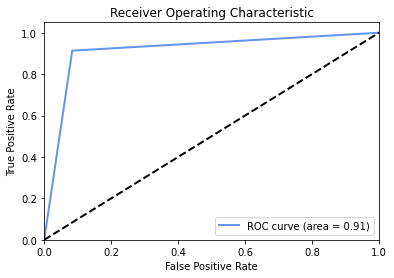

In [24]:
import pandas as pd
# prec_rec_curve(np.array(y_lable).ravel(), np.array(y_pred).ravel())
prec_rec_curve(np.concatenate( y_lable, axis=0 ), np.concatenate( y_pred, axis=0 ))

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
cm = confusion_matrix(np.concatenate( y_lable, axis=0 ), np.concatenate( y_pred, axis=0 ), normalize = 'true')

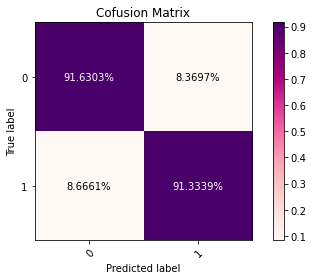

In [27]:
normalize = True
cmap = 'RdPu'
classes = [0, 1]
title = 'Cofusion Matrix'
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax = ax)
ax.set(xticks = np.arange(cm.shape[1]), yticks = np.arange(cm.shape[0]), xticklabels = classes, yticklabels = classes, ylabel = 'True label', xlabel = 'Predicted label', title = title)
plt.setp(ax.get_xticklabels(), rotation=45, ha = 'right', rotation_mode = 'anchor')
fmt = '.4%' if normalize else 'd'
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt), ha = 'center', va = 'center', color = 'white' if cm[i,j] > thresh else 'black')
        fig.tight_layout()


FileNotFoundError: [Errno 2] No such file or directory: 'figures/VAE_Loss_F1.jpg'

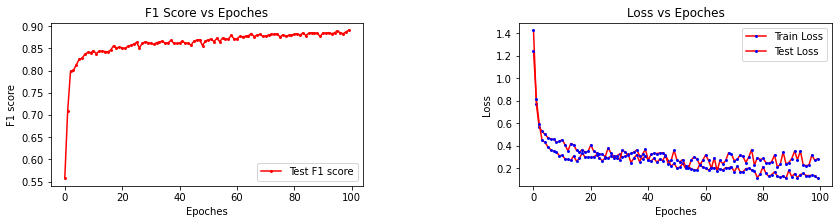

In [28]:
import torch
import pandas as pd
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

accuracy_list = torch.from_numpy(pd.read_csv('accuracy_list.csv').values).float()
precision_list = torch.from_numpy(pd.read_csv('precision_list.csv').values).float()
recall_list = torch.from_numpy(pd.read_csv('recall_list.csv').values).float()
F1_list = torch.from_numpy(pd.read_csv('F1_list.csv').values).float()
F1_list_train = torch.from_numpy(pd.read_csv('F1_list_train.csv').values).float()
loss_list = torch.from_numpy(pd.read_csv('loss_list.csv').values).float()
train_loss_list = torch.from_numpy(pd.read_csv('train_loss_list.csv').values).float()
train_var_list = torch.from_numpy(pd.read_csv('train_var_list.csv').values).float()
test_var_list = torch.from_numpy(pd.read_csv('test_var_list.csv').values).float()

totEpoch = 100
x = range(0, totEpoch)
plt.figure(figsize=(14,3))
grid = plt.GridSpec(3, 2, wspace=0.5, hspace=0.5)
plt.subplot(grid[:,0])
# plt.plot(x, F1_list_train, color="b", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Train F1 score')
plt.plot(x, F1_list, color="r", marker='o',markersize='1.5',markeredgecolor='r',markeredgewidth = 1.5, label = 'Test F1 score')
# plt.plot(x, train_var_list, color="g", marker='o',markersize='1.5',markeredgecolor='g',markeredgewidth = 1.5, label = 'Train variance')
#plt.plot(x, test_var_list, color="c", marker='o',markersize='1.5',markeredgecolor='c',markeredgewidth = 1.5, label = 'Test variance')
plt.legend()
plt.title('F1 Score vs Epoches')
plt.xlabel('Epoches')
plt.ylabel('F1 score')
plt.subplot(grid[:,1])
plt.plot(x, train_loss_list, color="red", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Train Loss')
plt.plot(x, loss_list, color="red", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Test Loss')
plt.legend()
plt.title('Loss vs Epoches')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.savefig('figures/VAE_Loss_F1.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'figures/VAE_Loss_F1.jpg'

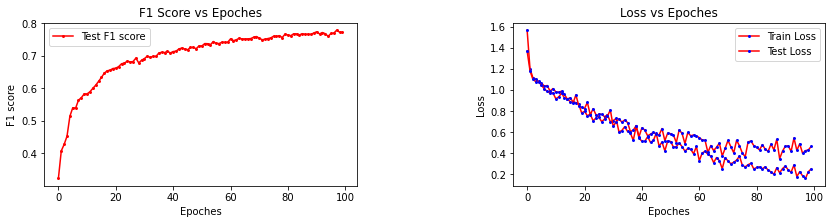

In [60]:
import torch
import pandas as pd
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

accuracy_list = torch.from_numpy(pd.read_csv('accuracy_list.csv').values).float()
precision_list = torch.from_numpy(pd.read_csv('precision_list.csv').values).float()
recall_list = torch.from_numpy(pd.read_csv('recall_list.csv').values).float()
F1_list = torch.from_numpy(pd.read_csv('F1_list.csv').values).float()
F1_list_train = torch.from_numpy(pd.read_csv('F1_list_train.csv').values).float()
loss_list = torch.from_numpy(pd.read_csv('loss_list.csv').values).float()
train_loss_list = torch.from_numpy(pd.read_csv('train_loss_list.csv').values).float()
train_var_list = torch.from_numpy(pd.read_csv('train_var_list.csv').values).float()
test_var_list = torch.from_numpy(pd.read_csv('test_var_list.csv').values).float()

totEpoch = 100
x = range(0, totEpoch)
plt.figure(figsize=(14,3))
grid = plt.GridSpec(3, 2, wspace=0.5, hspace=0.5)
plt.subplot(grid[:,0])
# plt.plot(x, F1_list_train, color="b", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Train F1 score')
plt.plot(x, F1_list, color="r", marker='o',markersize='1.5',markeredgecolor='r',markeredgewidth = 1.5, label = 'Test F1 score')
# plt.plot(x, train_var_list, color="g", marker='o',markersize='1.5',markeredgecolor='g',markeredgewidth = 1.5, label = 'Train variance')
#plt.plot(x, test_var_list, color="c", marker='o',markersize='1.5',markeredgecolor='c',markeredgewidth = 1.5, label = 'Test variance')
plt.legend()
plt.title('F1 Score vs Epoches')
plt.xlabel('Epoches')
plt.ylabel('F1 score')
plt.subplot(grid[:,1])
plt.plot(x, train_loss_list, color="red", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Train Loss')
plt.plot(x, loss_list, color="red", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Test Loss')
plt.legend()
plt.title('Loss vs Epoches')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.savefig('figures/VAE_Loss_F1.jpg')